<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/TransferLearning_in_NNIsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BTP

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import pickle
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from keras.utils import to_categorical
import keras.layers as layers
from keras import Sequential
from numba import jit

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import seaborn as sns


In [2]:
nu_G = 10
Ny = 64
Nx = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 50
lr = 0.001
beta1 = 0.5
ngpu = 1
N = Ny * Nx
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

### Plot function

In [30]:
def avg_prob(unique_temperatures, predictions, temperatures):
  # Initialize an array to store average prediction probabilities for each unique temperature
  average_probabilities = np.zeros_like(unique_temperatures, dtype=float)

  # Calculate average prediction probability for each unique temperature
  for i, temp in enumerate(unique_temperatures):
      # Find indices corresponding to the current unique temperature
      temp_indices = np.where(temperatures == temp)
      # Extract prediction probabilities for these indices
      temp_predictions = predictions[temp_indices]
      # Calculate average prediction probability
      average_prob = np.mean(temp_predictions)
      # Store the average probability
      average_probabilities[i] = average_prob
  return average_probabilities

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'predictions' is the array containing prediction probabilities
# and 'temperatures' is the array containing corresponding temperatures
def plot_proba(temperatures, predictions1, predictions2, label1 = 'Ordered state', label2 = 'Disordered state'):
# Calculate unique temperature values and their corresponding indices
  unique_temperatures, indices = np.unique(temperatures, return_inverse=True)
  avg_proba1 = avg_prob(unique_temperatures, predictions1, temperatures)
  avg_proba2 = avg_prob(unique_temperatures, predictions2, temperatures)

  # Plot the average prediction probabilities against temperature
  plt.figure(figsize=(8, 6))
  plt.plot(unique_temperatures, avg_proba1, marker='o', linestyle='-', label = label1)
  plt.plot(unique_temperatures, avg_proba2, marker='o', linestyle='-', label = label2)
  plt.legend()
  plt.xlabel('Temperature')
  plt.ylabel('Average Prediction Probability')
  plt.title('Average Prediction Probability per Temperature')

  plt.grid(True)
  plt.show()


### Model

#### Accuracy, train and test functions

In [3]:
def calculate_accuracy(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).float()

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape, e.g., labels = labels.view(-1, 1)

    # Calculate the number of correct predictions
    correct = (predicted == labels).float().sum().item()/2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.size(0)

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [4]:
def train(model, num_epochs, criterion, optimizer, train_dataloader):
  model.train()
  for epoch in range(num_epochs):
    for i, (x, label) in enumerate(train_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      b_size = x.size(0)
      model.zero_grad()
      output = model(x)
      # if(epoch==0 and i==0):
      #   print(output)
      error = criterion(output, label)
      error.backward()
      optimizer.step()
      acc_train = calculate_accuracy(output, label)
      if i % 20 == 0:
        print('Loss:', error.item(),',Train accuracy:', acc_train)

In [5]:
def test(model, criterion, test_dataloader):
    for i, (x, label) in enumerate(test_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      output = model(x)
      error = criterion(output, label)
      acc_train = calculate_accuracy(output, label)
      # if i % 20 == 0:
      print(i,':: Loss:', error.item(),',Test accuracy:', acc_train)

In [6]:
def get_predictions(test_loader, model):
    # Assuming `test_loader` is your DataLoader for the test dataset
    # Initialize lists to store predictions for each class
    predictions_class_1 = []
    predictions_class_2 = []

    with torch.no_grad():  # Disable gradient tracking during inference
        for inputs, _ in test_loader:
            inputs = inputs.to(device).float()  # Move inputs to the device (e.g., GPU)
            outputs = model(inputs)  # Forward pass to get predictions

            # Assuming the output is softmax probabilities
            # Separate the probabilities for class-1 and class-2
            class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
            class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

            predictions_class_1.extend(class_1_probs)
            predictions_class_2.extend(class_2_probs)

    # `predictions_class_1` contains the probabilities for class-1 for all test samples
    # `predictions_class_2` contains the probabilities for class-2 for all test samples
    # You can further process or save these predictions as needed
    return predictions_class_1, predictions_class_2


In [7]:
def get_predictions_np(input_matrix, model, device):
    # Convert numpy matrix to PyTorch tensor
    inputs = torch.tensor(input_matrix).to(device).float()

    # Forward pass to get predictions
    with torch.no_grad():  # Disable gradient tracking during inference
        outputs = model(inputs)  # Forward pass to get predictions

        # Assuming the output is softmax probabilities
        # Separate the probabilities for class-1 and class-2
        class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
        class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

    # `class_1_probs` contains the probabilities for class-1 for all samples
    # `class_2_probs` contains the probabilities for class-2 for all samples
    # You can further process or save these predictions as needed
    return class_1_probs, class_2_probs


#### File loaders

In [8]:
def file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    y = data['y']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15)
    Tc = 2.27 # For a square lattice following Ising Model
    y_train = Y_train > Tc
    y_test = Y_test > Tc
    y_train = to_categorical(y_train.astype(int))
    y_test = to_categorical(y_test.astype(int))
    return X_train, X_test, y_train, y_test, Y_train, Y_test

In [9]:
def full_file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    Y = data['y']
    # Tc = 2.27 # For a square lattice following Ising Model
    y = Y > Tc
    y = to_categorical(y.astype(int))
    return X, y, Y

#### Dataset and DataLoader

In [10]:
class IsingDataset(Dataset):
    def __init__(self, x, y, anti_ferro=False):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(torch.from_numpy(x))
        self.y = torch.tensor(torch.from_numpy(y))
        self.anti_ferro = anti_ferro

    def __getitem__(self, index):
        if self.anti_ferro:
            x_transformed = self._apply_anti_ferro(self.x[index])
            return x_transformed, self.y[index]
        else:
            return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

    def _apply_anti_ferro(self, x):
        # Apply anti-ferromagnetic transformation
        return (-1) ** torch.arange(x.size(0)).unsqueeze(1) + (-1) ** torch.arange(x.size(1))

# # Example usage
# x = ...  # Your input data
# y = ...  # Your target labels
# anti_ferro = True  # Set to True to apply the anti-ferromagnetic transformation
# dataset = IsingDataset(x, y, anti_ferro=anti_ferro)


In [11]:
import torch
from torch.utils.data import DataLoader

# Assuming you have a DataLoader named original_dataloader
# Define a new DataLoader class to subset the original DataLoader
class SubsetDataLoader(DataLoader):
    def __init__(self, dataloader, num_batches):
        super(SubsetDataLoader, self).__init__(dataloader.dataset, batch_size=dataloader.batch_size)
        self.dataloader = dataloader
        self.num_batches = num_batches
        self.current_batch = 0

    def __iter__(self):
        self.current_batch = 0
        self.dataloader_iter = iter(self.dataloader)
        return self

    def __next__(self):
        if self.current_batch >= self.num_batches:
            raise StopIteration
        self.current_batch += 1
        return next(self.dataloader_iter)

Train and test data:

In [72]:
# Anti-ferromagnetic dataset: train and test

X_train_anti, X_test_anti, y_train_anti, y_test_anti, Y_train_anti, Y_test_anti = file_loader('data.npz')

In [73]:
training_dataset_anti = IsingDataset(X_train_anti, y_train_anti)
testing_dataset_anti = IsingDataset(X_test_anti, y_test_anti)
batch_size = 128
train_dataloader_anti = DataLoader(dataset = training_dataset_anti, batch_size = batch_size, shuffle = False)
test_dataloader_anti = DataLoader(dataset = testing_dataset_anti, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


Class: [0. 1.]
Temperature: 3.5


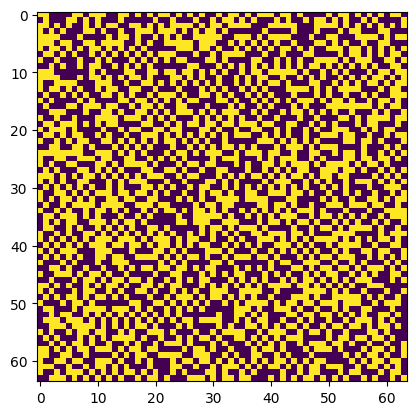

In [ ]:
plt.imshow(X_train_anti[30])
print("Class:", y_train_anti[30])
print("Temperature:", Y_train_anti[30])

#### Fully Connected Neural Network

In [ ]:
class neural_network(nn.Module):
  def __init__(self):
    super(neural_network, self).__init__()
    self.main = nn.Sequential(
        nn.Flatten(start_dim=1,end_dim=-1),
        nn.Linear(Nx*Ny, 100),
        nn.Sigmoid(),
        nn.Linear(100, 2),
        nn.Sigmoid()
    )
  def forward(self, input):
      return self.main(input)

In [ ]:
FCNN = neural_network().to(device)
criterion_FCNN = nn.BCELoss()
optimizer_FCNN = optim.Adam(FCNN.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
# # Dataset 1, NN -> antiFe, NNN -> Fe
# X_anti, y_anti, Y_anti = full_file_loader('data_anti.npz')
# dataset_anti = IsingDataset(X_anti, y_anti)
# batch_size = 128
# dataloader_anti = DataLoader(dataset = dataset_anti, batch_size = batch_size, shuffle = False)

In [ ]:
train(FCNN, 10, criterion_FCNN, optimizer_FCNN, train_dataloader_anti)

Loss: 0.694808840751648 ,Train accuracy: 0.6015625
Loss: 0.6998928785324097 ,Train accuracy: 0.4765625
Loss: 0.6956212520599365 ,Train accuracy: 0.703125
Loss: 0.6933309435844421 ,Train accuracy: 0.5390625
Loss: 0.6729944348335266 ,Train accuracy: 0.546875
Loss: 0.6664677858352661 ,Train accuracy: 0.79296875
Loss: 0.7108287215232849 ,Train accuracy: 0.49609375
Loss: 0.6884220838546753 ,Train accuracy: 0.75
Loss: 0.6801477670669556 ,Train accuracy: 0.57421875
Loss: 0.6276676654815674 ,Train accuracy: 0.8671875
Loss: 0.6431004405021667 ,Train accuracy: 0.7734375
Loss: 0.6468219757080078 ,Train accuracy: 0.75390625
Loss: 0.6360934972763062 ,Train accuracy: 0.7890625
Loss: 0.601184606552124 ,Train accuracy: 0.8125
Loss: 0.566032886505127 ,Train accuracy: 0.8671875
Loss: 0.6966426372528076 ,Train accuracy: 0.79296875
Loss: 0.6068639159202576 ,Train accuracy: 0.80859375
Loss: 0.5976171493530273 ,Train accuracy: 0.8203125
Loss: 0.570264995098114 ,Train accuracy: 0.83203125
Loss: 0.52796196937

In [ ]:
test(FCNN, criterion_FCNN, test_dataloader_anti)

0 :: Loss: 0.1944330930709839 ,Test accuracy: 0.9296875
1 :: Loss: 0.3490474820137024 ,Test accuracy: 0.87890625
2 :: Loss: 0.2394697368144989 ,Test accuracy: 0.93359375
3 :: Loss: 0.3447885811328888 ,Test accuracy: 0.90625
4 :: Loss: 0.3742731213569641 ,Test accuracy: 0.890625
5 :: Loss: 0.1726294755935669 ,Test accuracy: 0.9375
6 :: Loss: 0.37815940380096436 ,Test accuracy: 0.89453125
7 :: Loss: 0.35600364208221436 ,Test accuracy: 0.890625
8 :: Loss: 0.22086834907531738 ,Test accuracy: 0.90625
9 :: Loss: 0.38123810291290283 ,Test accuracy: 0.875
10 :: Loss: 0.22011587023735046 ,Test accuracy: 0.9375
11 :: Loss: 0.39048415422439575 ,Test accuracy: 0.8671875
12 :: Loss: 0.5222269296646118 ,Test accuracy: 0.8671875
13 :: Loss: 0.22922751307487488 ,Test accuracy: 0.91015625
14 :: Loss: 0.31962859630584717 ,Test accuracy: 0.875
15 :: Loss: 0.3035730719566345 ,Test accuracy: 0.9296875
16 :: Loss: 0.4342727065086365 ,Test accuracy: 0.86328125
17 :: Loss: 0.3147673010826111 ,Test accuracy: 0

#### CNN:

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class ConvNet(nn.Module):
    def __init__(self, Nx, Ny):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=0)
        self.out_conv1 = self._calculate_output_size((Nx, Ny), kernel_size=2, padding=0)
        self.fc1 = nn.Linear(64 * self.out_conv1[0] * self.out_conv1[1], 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 2)
        self.flatten = nn.Flatten()

    def forward(self, x, return_feature_maps=False):
        x = x.view(-1, 1, x.size(1), x.size(2))
        x = F.relu(self.conv1(x))
        if return_feature_maps:
            return x
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return F.softmax(self.fc2(x), dim=1)

    def _calculate_output_size(self, input_size, kernel_size, padding):
        out_size = [(input_size[0] - kernel_size + 2 * padding) + 1,
                    (input_size[1] - kernel_size + 2 * padding) + 1]
        return out_size

## Example Usage:
# model = ConvNet(40, 40)
# x = torch.randn(1, 40, 40)
# feature_maps = model(x, return_feature_maps=True)

## Plotting the first feature map from the first sample in the batch
# plt.imshow(feature_maps[0, 0].detach().numpy(), cmap='gray')
# plt.colorbar()
# plt.title('Feature Map from Conv1')
# plt.show()


In [15]:
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['binary_accuracy'])
CNN = ConvNet(Nx, Ny).to(device)
criterion_CNN = nn.BCELoss()
optimizer_CNN = optim.Adam(CNN.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [16]:
train(CNN, 10, criterion_CNN, optimizer_CNN, train_dataloader_anti)

Loss: 0.7158989906311035 ,Train accuracy: 0.46875
Loss: 0.07141352444887161 ,Train accuracy: 0.984375
Loss: 0.04949726164340973 ,Train accuracy: 0.9765625
Loss: 0.036825329065322876 ,Train accuracy: 0.984375
Loss: 0.08527529239654541 ,Train accuracy: 0.96875
Loss: 0.04734307527542114 ,Train accuracy: 0.984375
Loss: 0.039266299456357956 ,Train accuracy: 0.9921875
Loss: 0.046109095215797424 ,Train accuracy: 0.984375
Loss: 0.050646089017391205 ,Train accuracy: 0.984375
Loss: 0.07380016148090363 ,Train accuracy: 0.9765625
Loss: 0.05429656803607941 ,Train accuracy: 0.9765625
Loss: 0.06521183252334595 ,Train accuracy: 0.9765625
Loss: 0.032413795590400696 ,Train accuracy: 0.9921875
Loss: 0.05803576111793518 ,Train accuracy: 0.9765625
Loss: 0.019568730145692825 ,Train accuracy: 1.0
Loss: 0.024035576730966568 ,Train accuracy: 1.0
Loss: 0.04011247679591179 ,Train accuracy: 0.984375
Loss: 0.027717040851712227 ,Train accuracy: 0.9921875
Loss: 0.058631978929042816 ,Train accuracy: 0.984375
Loss: 0.

In [17]:
test(CNN, criterion_CNN, test_dataloader_anti)

0 :: Loss: 0.010692549869418144 ,Test accuracy: 0.9921875
1 :: Loss: 0.05917436257004738 ,Test accuracy: 0.984375
2 :: Loss: 0.0815957635641098 ,Test accuracy: 0.96875
3 :: Loss: 0.000419312302256003 ,Test accuracy: 1.0
4 :: Loss: 0.005190838128328323 ,Test accuracy: 1.0
5 :: Loss: 0.03405211120843887 ,Test accuracy: 0.9921875
6 :: Loss: 0.03532478213310242 ,Test accuracy: 0.9921875
7 :: Loss: 0.04566677659749985 ,Test accuracy: 0.984375
8 :: Loss: 0.022086700424551964 ,Test accuracy: 0.984375
9 :: Loss: 0.0667322650551796 ,Test accuracy: 0.96875
10 :: Loss: 0.01905384287238121 ,Test accuracy: 0.9921875
11 :: Loss: 0.012468075379729271 ,Test accuracy: 0.9921875
12 :: Loss: 0.02157747745513916 ,Test accuracy: 0.984375
13 :: Loss: 0.005751272663474083 ,Test accuracy: 1.0
14 :: Loss: 0.014235813170671463 ,Test accuracy: 0.9921875
15 :: Loss: 0.04678254574537277 ,Test accuracy: 0.9921875
16 :: Loss: 0.011862188577651978 ,Test accuracy: 1.0
17 :: Loss: 0.036604784429073334 ,Test accuracy: 0

In [18]:
torch.save(CNN.state_dict(), 'CNN_anti.pth')

### Feature Maps

In [ ]:
# Example Usage:
# model = ConvNet(40, 40)
def plot_feature_map(model, x, y, print_data = False):
  x = torch.from_numpy(x).unsqueeze(0).float().to(device)
  feature_maps = model(x, return_feature_maps=True)

  # Plotting the first feature map from the first sample in the batch
  data = feature_maps[0, 0].cpu().detach().numpy()
  print(data)
  plt.imshow(data)
  plt.colorbar()
  plt.title(f'Temperature={y}')
  plt.show()

Text(0.5, 1.0, 'Temperature=1.5')

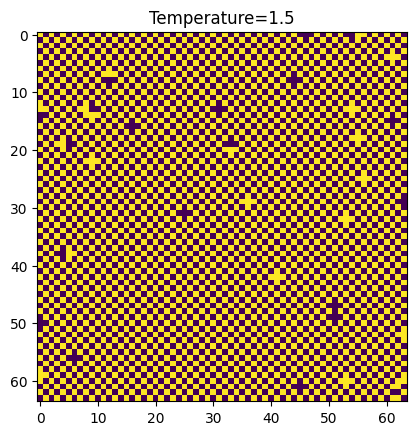

In [ ]:
plt.imshow(X_train_anti[0])
plt.title(f"Temperature={Y_train_anti[0]}")

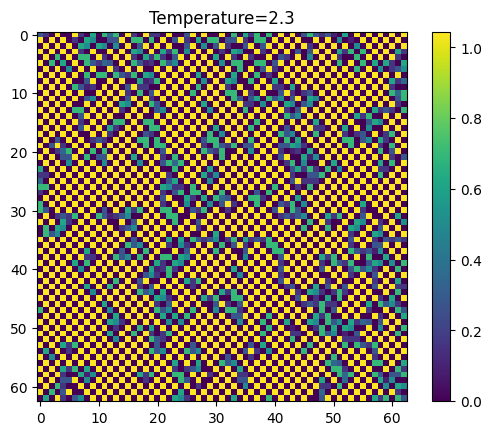

In [ ]:
plot_feature_map(CNN, X_train_anti[2000], Y_train_anti[2000])

### Transfer Learning

In [69]:
# Anti-ferromagnetic dataset: train and test

# X_train8, X_test8, y_train8, y_test8, Y_train8, Y_test8 = file_loader('data_64NNN_anti_noshuffle_Rplus2.npz', 4)
X_train8, X_test8, y_train8, y_test8, Y_train8, Y_test8 = file_loader('data_anti.npz')

In [70]:
training_dataset8 = IsingDataset(X_train8, y_train8)
testing_dataset8 = IsingDataset(X_test8, y_test8)
batch_size = 128
train_dataloader8 = DataLoader(dataset = training_dataset8, batch_size = batch_size, shuffle = False)
test_dataloader8 = DataLoader(dataset = testing_dataset8, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [71]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
CNN2 = ConvNet(Nx, Ny)  # or load from saved state
CNN2.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam(CNN2.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(CNN2, num_epochs=10, criterion=criterion, optimizer=optimizer, train_dataloader=train_dataloader8)


Loss: 0.7104041576385498 ,Train accuracy: 0.4921875
Loss: 0.022433515638113022 ,Train accuracy: 0.9921875
Loss: 0.014457939192652702 ,Train accuracy: 0.9921875
Loss: 0.019788939505815506 ,Train accuracy: 1.0
Loss: 0.013228578492999077 ,Train accuracy: 1.0
Loss: 0.10820487141609192 ,Train accuracy: 0.984375
Loss: 0.004950387869030237 ,Train accuracy: 1.0
Loss: 0.009963881224393845 ,Train accuracy: 1.0
Loss: 0.033319082111120224 ,Train accuracy: 0.9921875
Loss: 0.032166022807359695 ,Train accuracy: 0.9921875
Loss: 0.0742993950843811 ,Train accuracy: 0.96875
Loss: 0.0032796303275972605 ,Train accuracy: 1.0
Loss: 0.022587887942790985 ,Train accuracy: 0.984375
Loss: 0.014682767912745476 ,Train accuracy: 0.9921875
Loss: 0.011150699108839035 ,Train accuracy: 0.9921875
Loss: 0.005143176764249802 ,Train accuracy: 1.0
Loss: 0.02902306243777275 ,Train accuracy: 0.984375
Loss: 0.013138706795871258 ,Train accuracy: 0.9921875
Loss: 0.0063751935958862305 ,Train accuracy: 1.0
Loss: 0.09115596860647202

In [23]:
# test(CNN2, criterion, dataloader8)

In [ ]:
pred_class1, pred_class2 = get_predictions(dataloader8, CNN2)

In [ ]:
plt.scatter(Y8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y8, pred_class2, label='Paramagnetic')
plt.legend()

###### Transfer learning on ferromagnetic data

In [24]:
training_dataset8 = IsingDataset(X_train8, y_train8)
testing_dataset8 = IsingDataset(X_test8, y_test8)
batch_size = 128
train_dataloader_shuffle = DataLoader(dataset = training_dataset8, batch_size = batch_size, shuffle = True)
test_dataloader_shuffle = DataLoader(dataset = testing_dataset8, batch_size = batch_size, shuffle = True)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [60]:
# Create the new DataLoader containing the first 20 batches of the original DataLoader
num_batches_to_take = 10
new_dataloader = SubsetDataLoader(train_dataloader_shuffle, num_batches_to_take)

# Now you can iterate over new_dataloader to access the first 20 batches of the original DataLoader
for batch_idx, (data, labels) in enumerate(new_dataloader):
    print(f"Batch {batch_idx + 1}: Data shape: {data.shape}, Labels shape: {labels.shape}")

Batch 1: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 2: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 3: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 4: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 5: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 6: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 7: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 8: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 9: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 10: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])


In [61]:
CNNferro = ConvNet(Nx, Ny)  # or load from saved state
CNNferro.to(device)
# Setup optimizer - only optimize the unfrozen parameters
optimizer_ferro = optim.Adam(CNNferro.parameters(), lr=1e-4, betas=[0.9,0.999])
# Define the loss function
criterion = nn.BCELoss()
# Example usage of the training function with dataloader8
train(CNNferro, num_epochs=2, criterion=criterion, optimizer=optimizer_ferro, train_dataloader=new_dataloader)

Loss: 0.6929371356964111 ,Train accuracy: 0.546875
Loss: 0.4204752445220947 ,Train accuracy: 0.84375


In [62]:
pred_class1, pred_class2 = get_predictions(train_dataloader8, CNNferro)

Text(0, 0.5, 'Probability')

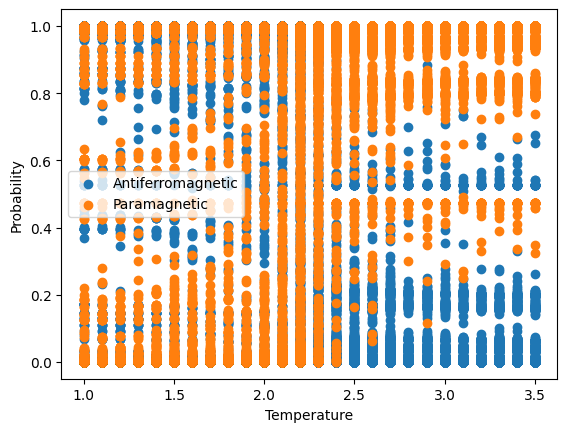

In [63]:
plt.scatter(Y_train8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_train8, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability')

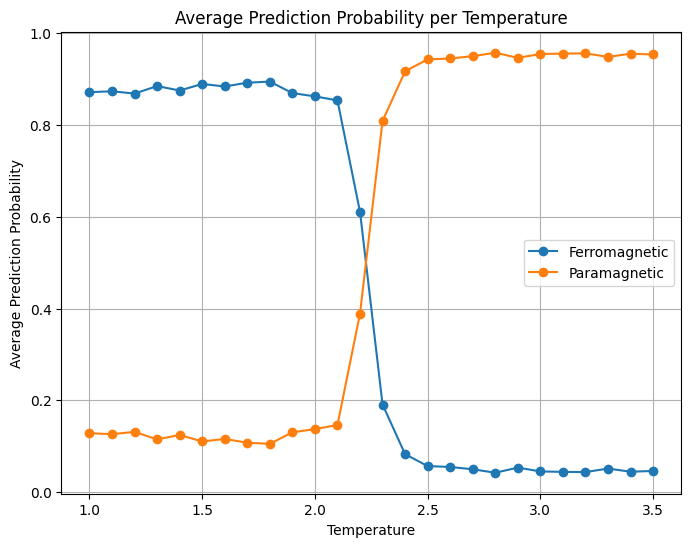

In [64]:
plot_proba(np.array(Y_train8), np.array(pred_class1), np.array(pred_class2), 'Ferromagnetic', 'Paramagnetic')

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model = ConvNet(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model.conv1.weight.data = pretrained_model.conv1.weight.data
model.conv1.bias.data = pretrained_model.conv1.bias.data
# model.fc1.weight.data = pretrained_model.fc1.weight.data
# model.fc1.bias.data = pretrained_model.fc1.bias.data
model.fc2.weight.data = pretrained_model.fc2.weight.data
model.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model.fc1.weight.requires_grad = True
model.fc1.bias.requires_grad = True
# model.fc2.weight.requires_grad = True
# model.fc2.bias.requires_grad = True

model.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}
], lr=1e-4, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model, num_epochs=2, criterion=criterion, optimizer=optimizer, train_dataloader=new_dataloader)


Loss: 0.6963088512420654 ,Train accuracy: 0.53125
Loss: 0.25909754633903503 ,Train accuracy: 0.9453125


In [66]:
pred_class1, pred_class2 = get_predictions(train_dataloader8, model)

Text(0, 0.5, 'Probability')

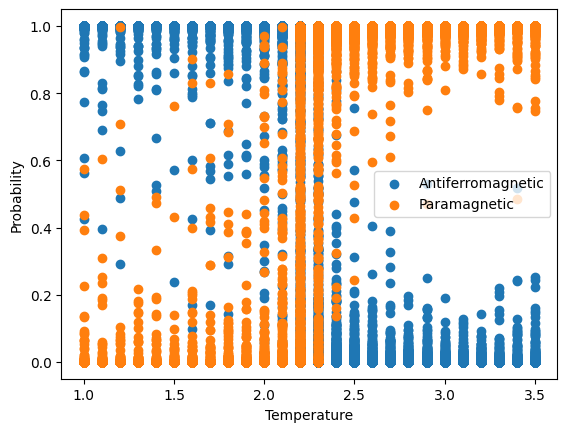

In [67]:
plt.scatter(Y_train8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_train8, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability')

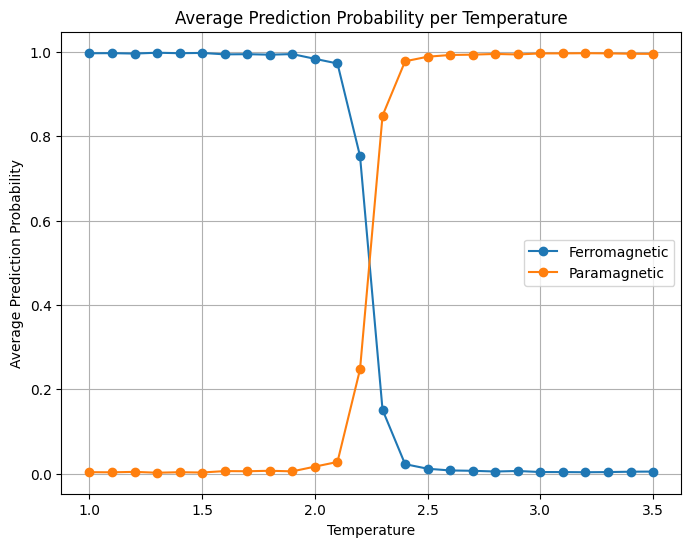

In [68]:
plot_proba(np.array(Y_train8), np.array(pred_class1), np.array(pred_class2), 'Ferromagnetic', 'Paramagnetic')

###### Transfer learning on anti-ferromagnetic data

In [74]:
training_dataset8 = IsingDataset(X_train8, y_train8)
testing_dataset8 = IsingDataset(X_test8, y_test8)
batch_size = 128
train_dataloader_shuffle = DataLoader(dataset = training_dataset8, batch_size = batch_size, shuffle = True)
test_dataloader_shuffle = DataLoader(dataset = testing_dataset8, batch_size = batch_size, shuffle = True)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [75]:
# Create the new DataLoader containing the first 20 batches of the original DataLoader
num_batches_to_take = 10
new_dataloader = SubsetDataLoader(train_dataloader_shuffle, num_batches_to_take)

# Now you can iterate over new_dataloader to access the first 20 batches of the original DataLoader
for batch_idx, (data, labels) in enumerate(new_dataloader):
    print(f"Batch {batch_idx + 1}: Data shape: {data.shape}, Labels shape: {labels.shape}")

Batch 1: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 2: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 3: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 4: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 5: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 6: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 7: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 8: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 9: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])
Batch 10: Data shape: torch.Size([128, 64, 64]), Labels shape: torch.Size([128, 2])


In [76]:
CNNferro = ConvNet(Nx, Ny)  # or load from saved state
CNNferro.to(device)
# Setup optimizer - only optimize the unfrozen parameters
optimizer_ferro = optim.Adam(CNNferro.parameters(), lr=1e-4, betas=[0.9,0.999])
# Define the loss function
criterion = nn.BCELoss()
# Example usage of the training function with dataloader8
train(CNNferro, num_epochs=2, criterion=criterion, optimizer=optimizer_ferro, train_dataloader=new_dataloader)

Loss: 0.6838029026985168 ,Train accuracy: 0.5078125
Loss: 0.1632499396800995 ,Train accuracy: 0.96875


In [77]:
pred_class1, pred_class2 = get_predictions(train_dataloader8, CNNferro)

Text(0, 0.5, 'Probability')

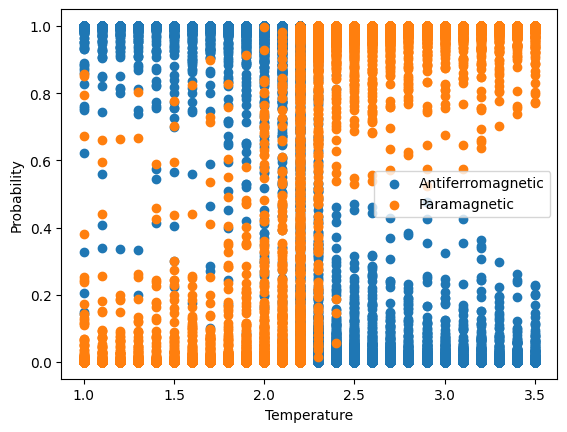

In [78]:
plt.scatter(Y_train8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_train8, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability')

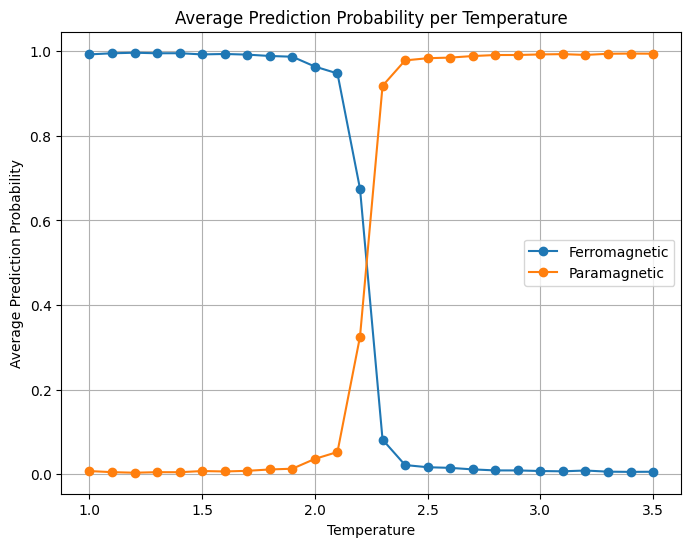

In [79]:
plot_proba(np.array(Y_train8), np.array(pred_class1), np.array(pred_class2), 'Ferromagnetic', 'Paramagnetic')

##### FC2 initialized

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model = ConvNet(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model.conv1.weight.data = pretrained_model.conv1.weight.data
model.conv1.bias.data = pretrained_model.conv1.bias.data
# model.fc1.weight.data = pretrained_model.fc1.weight.data
# model.fc1.bias.data = pretrained_model.fc1.bias.data
model.fc2.weight.data = pretrained_model.fc2.weight.data
model.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model.fc1.weight.requires_grad = True
model.fc1.bias.requires_grad = True
# model.fc2.weight.requires_grad = True
# model.fc2.bias.requires_grad = True

model.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}
], lr=1e-4, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model, num_epochs=2, criterion=criterion, optimizer=optimizer, train_dataloader=new_dataloader)


Loss: 0.7527251243591309 ,Train accuracy: 0.421875
Loss: 0.17531445622444153 ,Train accuracy: 0.921875


In [81]:
pred_class1, pred_class2 = get_predictions(train_dataloader8, model)

Text(0, 0.5, 'Probability')

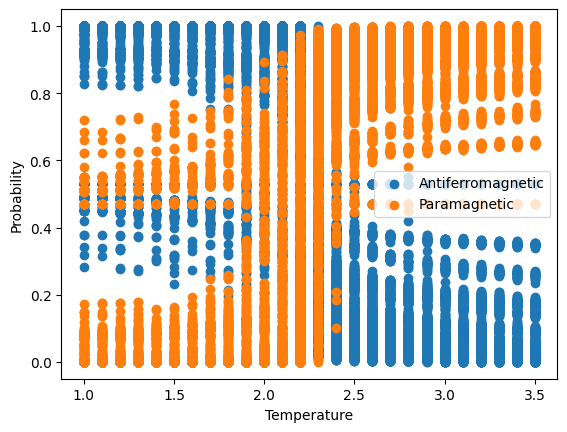

In [82]:
plt.scatter(Y_train8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_train8, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability')

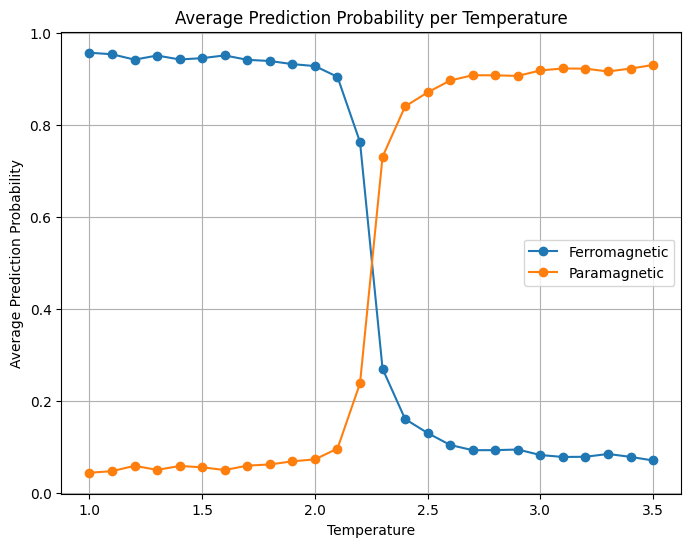

In [83]:
plot_proba(np.array(Y_train8), np.array(pred_class1), np.array(pred_class2), 'Ferromagnetic', 'Paramagnetic')

##### FC1 initialized

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model = ConvNet(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model.conv1.weight.data = pretrained_model.conv1.weight.data
model.conv1.bias.data = pretrained_model.conv1.bias.data
model.fc1.weight.data = pretrained_model.fc1.weight.data
model.fc1.bias.data = pretrained_model.fc1.bias.data
# model.fc2.weight.data = pretrained_model.fc2.weight.data
# model.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model.fc1.weight.requires_grad = True
model.fc1.bias.requires_grad = True
# model.fc2.weight.requires_grad = True
# model.fc2.bias.requires_grad = True

model.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}
], lr=1e-4, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model, num_epochs=2, criterion=criterion, optimizer=optimizer, train_dataloader=new_dataloader)


Loss: 11.671606063842773 ,Train accuracy: 0.4296875
Loss: 7.140885353088379 ,Train accuracy: 0.578125


In [85]:
pred_class1, pred_class2 = get_predictions(train_dataloader8, model)

Text(0, 0.5, 'Probability')

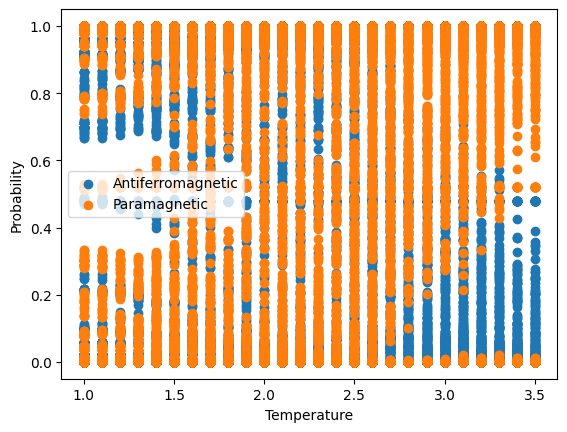

In [86]:
plt.scatter(Y_train8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_train8, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability')

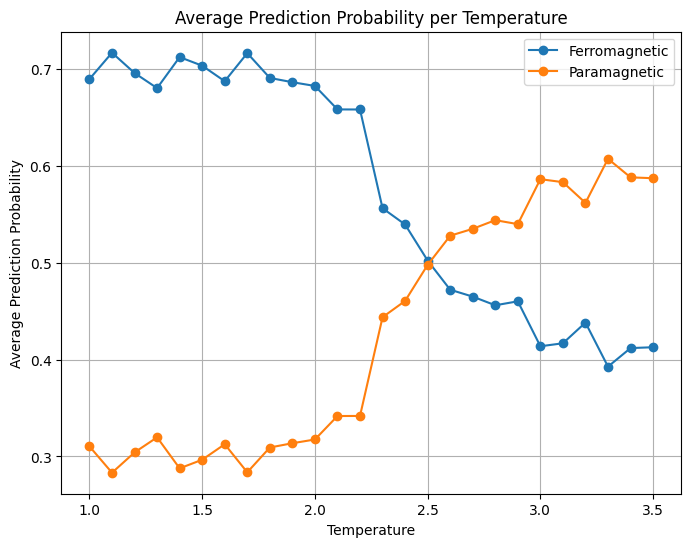

In [87]:
plot_proba(np.array(Y_train8), np.array(pred_class1), np.array(pred_class2), 'Ferromagnetic', 'Paramagnetic')

##### Both un-initialized

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model = ConvNet(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model.conv1.weight.data = pretrained_model.conv1.weight.data
model.conv1.bias.data = pretrained_model.conv1.bias.data
# model.fc1.weight.data = pretrained_model.fc1.weight.data
# model.fc1.bias.data = pretrained_model.fc1.bias.data
# model.fc2.weight.data = pretrained_model.fc2.weight.data
# model.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model.fc1.weight.requires_grad = True
model.fc1.bias.requires_grad = True
# model.fc2.weight.requires_grad = True
# model.fc2.bias.requires_grad = True

model.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}
], lr=1e-4, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model, num_epochs=2, criterion=criterion, optimizer=optimizer, train_dataloader=new_dataloader)


Loss: 0.6870695352554321 ,Train accuracy: 0.5
Loss: 0.09102778136730194 ,Train accuracy: 0.96875


In [89]:
pred_class1, pred_class2 = get_predictions(train_dataloader8, model)

Text(0, 0.5, 'Probability')

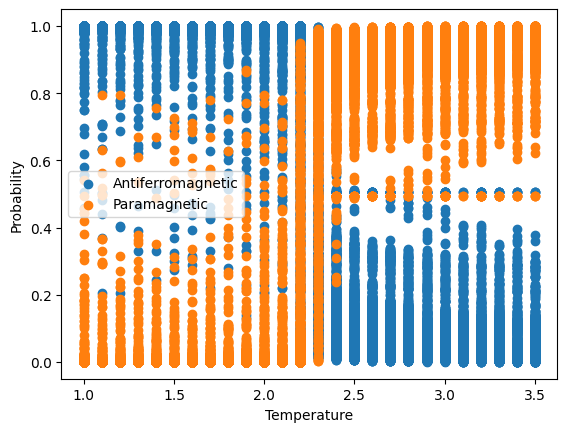

In [90]:
plt.scatter(Y_train8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_train8, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability')

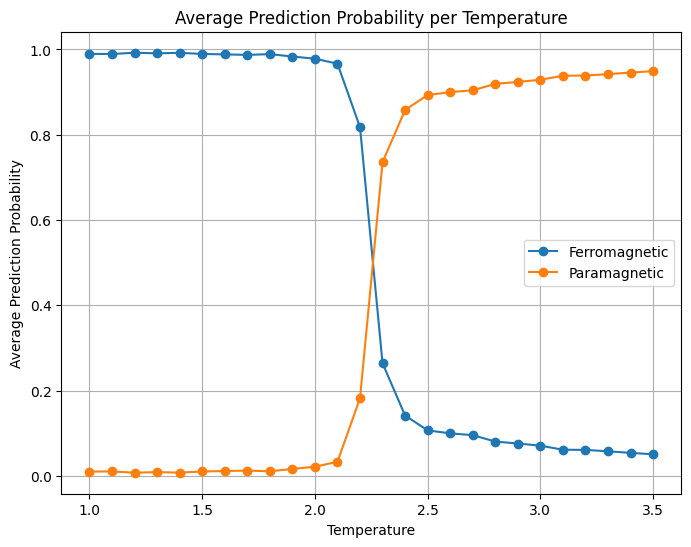

In [91]:
plot_proba(np.array(Y_train8), np.array(pred_class1), np.array(pred_class2), 'Ferromagnetic', 'Paramagnetic')

##### Both initialized

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim

# Load your pre-trained model
model = ConvNet(Nx, Ny)  # or load from saved state
pretrained_model = ConvNet(Nx, Ny)
state_dict = torch.load("CNN_anti.pth")
pretrained_model.load_state_dict(state_dict)
model.conv1.weight.data = pretrained_model.conv1.weight.data
model.conv1.bias.data = pretrained_model.conv1.bias.data
model.fc1.weight.data = pretrained_model.fc1.weight.data
model.fc1.bias.data = pretrained_model.fc1.bias.data
model.fc2.weight.data = pretrained_model.fc2.weight.data
model.fc2.bias.data = pretrained_model.fc2.bias.data

# Freeze all parameters in the model first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the layers that you want to train (fc1 and fc2)
model.fc1.weight.requires_grad = True
model.fc1.bias.requires_grad = True
# model.fc2.weight.requires_grad = True
# model.fc2.bias.requires_grad = True

model.to(device)

# Setup optimizer - only optimize the unfrozen parameters
optimizer = optim.Adam([
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}
], lr=1e-4, betas=[0.9,0.999])
# optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=[0.9,0.999])

# Define the loss function
criterion = nn.BCELoss()


# Example usage of the training function with dataloader8
train(model, num_epochs=2, criterion=criterion, optimizer=optimizer, train_dataloader=new_dataloader)


Loss: 0.00015928788343444467 ,Train accuracy: 1.0
Loss: 0.12212316691875458 ,Train accuracy: 0.9765625


In [93]:
pred_class1, pred_class2 = get_predictions(train_dataloader8, model)

Text(0, 0.5, 'Probability')

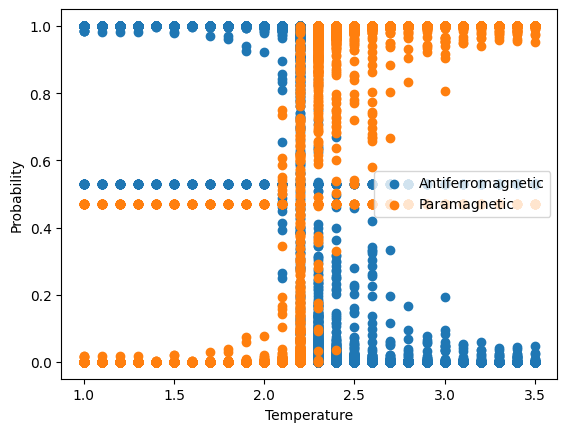

In [94]:
plt.scatter(Y_train8, pred_class1, label='Antiferromagnetic')
plt.scatter(Y_train8, pred_class2, label='Paramagnetic')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Probability')

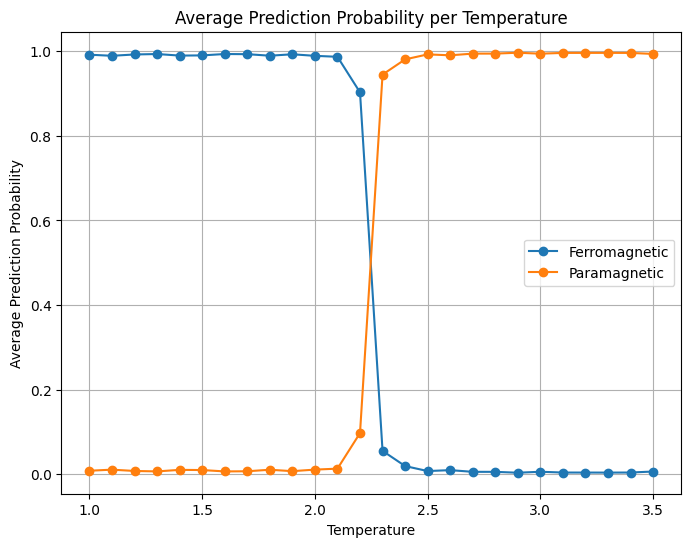

In [95]:
plot_proba(np.array(Y_train8), np.array(pred_class1), np.array(pred_class2), 'Ferromagnetic', 'Paramagnetic')